#Importing Libraries

In [59]:
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

get_ipython().magic(u'matplotlib inline')


In [60]:
def split_sequence(sequence, n_steps=7, lookahead=0):
    X, y = list(), list()
    for i in range(lookahead,len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i-lookahead:end_ix-lookahead], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Data preprocessing

In [61]:
tsdataframe = pd.read_csv('timeseries_lab3.csv')
print("Timeseries CSV Head:\n", tsdataframe.head())

Timeseries CSV Head:
        Date       Price
0  1/1/2006  569.865168
1  1/2/2006  593.271930
2  1/3/2006  606.471193
3  1/4/2006  576.932773
4  1/5/2006  573.812500


In [62]:
tsdata = np.load('timeseries_lab3.npy')
print("Timeseries Data Shape:", tsdata.shape)


Timeseries Data Shape: (3652,)


In [63]:
tsdata

array([569.86516854, 593.27192983, 606.47119342, ..., 856.88391039,
       888.00221239, 918.49879518])

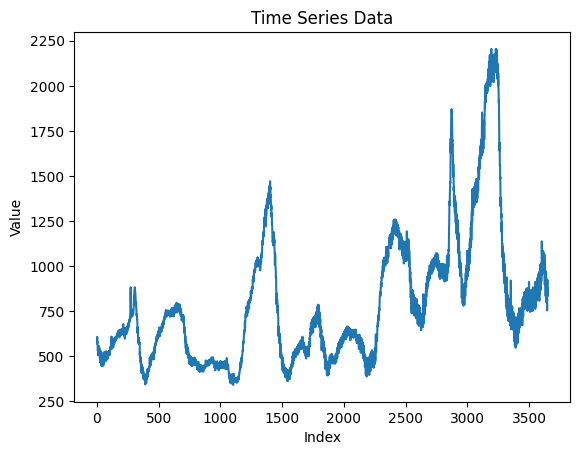

In [64]:
plt.plot(tsdata)
plt.title('Time Series Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [65]:
n_steps=7
n_features = 1
train_size = 2557

In [66]:
# Check if train_size is valid
if train_size > len(tsdata):
    raise ValueError("train_size exceeds the length of the dataset.")

In [67]:
X, y = split_sequence(tsdata,n_steps)

In [68]:
# Ensure there are enough labels
if len(y) < train_size:
    raise ValueError("Not enough labels to match the specified train_size.")

In [69]:
#tsdata[:15]

In [70]:
#X[:10]

In [71]:
#y[:4]

In [72]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
trainX = X[:train_size]
trainy = y[:train_size]
testX = X[train_size:]
testy = y[train_size:]

In [73]:
#trainX

### LSTM model for time series prediction

In [74]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [75]:
model.fit(trainX, trainy, epochs=20, verbose=1)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 363164.9062
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 786.3948
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 665.1196
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 714.8715
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 651.0495
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 799.7881
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 728.5591
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 751.8549
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 730.7618
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 640.7651
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 640.8234
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 639.8798
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 636.3978
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 609.2324
Epoch 15/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

### Prediction (test set)

In [76]:
yhat = model.predict(testX, verbose=0)

In [77]:
pred = np.array([yhat[i] for i in range(yhat.shape[0])])

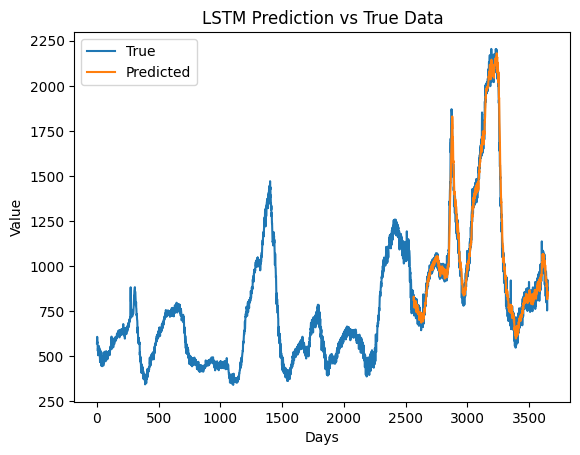

In [78]:
plt.plot(range(len(tsdata)), tsdata, label='True')
plt.plot(range(len(tsdata)-len(testy), len(tsdata)), pred, label='Predicted')
plt.legend(loc='upper left')
plt.title('LSTM Prediction vs True Data')
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()



## Lab 4: Language Model

<b>Problem statement:</b> Use the following dataset containing element names to train a language model. Generate new names using the trained model. The generated names should resemble element names, e.g. ends with '-ium'

### Data

In [79]:
data = open('/content/elements.txt', 'r').read()
data= data.lower()
chars = list(set('\n'.join(data)))
data_size, vocab_size = len(data), len(chars)
char_to_index = { ch:i for i,ch in enumerate(chars) }
index_to_char = { i:ch for i,ch in enumerate(chars) }
char_to_index[' '] = len(chars)
data_size, vocab_size = len(data), len(chars)

In [80]:
data

'hydrogen\nhelium\nlithium\nberyllium\nboron\ncarbon\nnitrogen\noxygen\nfluorine\nneon\nsodium\nmagnesium\naluminium\nsilicon\nphosphorus\nsulfur\nchlorine\nargon\npotassium\ncalcium\nscandium\ntitanium\nvanadium\nchromium\nmanganese\niron\ncobalt\nnickel\ncopper\nzinc\ngallium\ngermanium\narsenic\nselenium\nbromine\nkrypton\nrubidium\nstrontium\nyttrium\nzirconium\nniobium\nmolybdenum\ntechnetium\nruthenium\nrhodium\npalladium\nsilver\ncadmium\nindium\ntin\nantimony\ntellurium\niodine\nxenon\ncesium\nbarium\nlanthanum\ncerium\npraseodymium\nneodymium\npromethium\nsamarium\neuropium\ngadolinium\nterbium\ndysprosium\nholmium\nerbium\nthulium\nytterbium\nlutetium\nhafnium\ntantalum\ntungsten\nrhenium\nosmium\niridium\nplatinum\ngold\nmercury\nthallium\nlead\nbismuth\npolonium\nastatine\nradon\nfrancium\nradium\nactinium\nthorium\nprotactinium\nuranium\nneptunium\nplutonium\namericium\ncurium\nberkelium\ncalifornium\neinsteinium\nfermium\nmendelevium\nnobelium\nlawrencium\nrutherfordium\n

In [81]:
import tensorflow as tf
import numpy as np

# Loading the dataset and preprocess
with open('/content/elements.txt') as f:
    dataset = f.read().split()

chars = sorted(set(''.join(dataset)))

char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}
data = [char_to_int[c] for c in ''.join(dataset)]

# Prepare sequences
seq_length = 10
sequences = []
for i in range(len(data) - seq_length):
    sequences.append(data[i:i+seq_length])

X = np.array(sequences)
y = tf.keras.utils.to_categorical(X[:, -1], num_classes=len(chars))
X = X[:, :-1]

# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(chars), output_dim=128, input_length=seq_length-1),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.30),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(chars), activation='softmax')
])

# Compiling the model with accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X, y, epochs=100, verbose=1)

# Generating words ending with '-ium'
generated_words = []
while len(generated_words) < 10:
    start = np.random.randint(0, len(data)-seq_length)
    seq = data[start:start+seq_length-1]
    generated_text = ''.join([int_to_char[i] for i in seq])

    for i in range(20):
        x = np.array([seq])
        y_pred = model.predict(x, verbose=0)[0]
        next_char = int_to_char[np.argmax(y_pred)]
        generated_text += next_char
        seq = seq[1:] + [char_to_int[next_char]]

        if generated_text.endswith('ium'):
            generated_words.append(generated_text)
            break



Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0965 - loss: 3.1097
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1077 - loss: 2.8104
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1208 - loss: 2.7518
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1365 - loss: 2.7797
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1219 - loss: 2.8403
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1208 - loss: 2.7630
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1552 - loss: 2.6984
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1983 - loss: 2.6412
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2359 - loss: 2.5427
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2740 - loss: 2.4968
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2901 - loss: 2.4417
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3396 

In [82]:
def print_results(generated_words, history):
    # Printing generated words
    print("Generated Words Ending with '-ium':")
    for word in generated_words:
        print(word)

    # Printing final accuracy and loss
    final_loss = history.history['loss'][-1]
    final_accuracy = history.history['accuracy'][-1]
    print(f"\nFinal Training Loss: {final_loss:.4f}")
    print(f"Final Training Accuracy: {final_accuracy:.4f}")

print_results(generated_words, history)


Generated Words Ending with '-ium':
rmstadtium
eriumpraseodymium
agnesiumaluminium
tnickelcopperzincgallium
mindiumtinantimonytellurium
oviumlivermorium
sulfurchlorineargonpotassium
heniumosmium
niumcopernicium
ivermorium

Final Training Loss: 0.1123
Final Training Accuracy: 0.9594


### Model Architecture

<img src="rnn_langmod.png" style="width:500;height:300px;">